## Introduction


### 📝 **Comparing Different Indexes for Vector Databases**

In this post, we'll explore and compare different indexing techniques for nearest neighbor search in vector databases.

Most VectorDB systems (like FAISS, Milvus, Pinecone, etc.) rely on internal indexing strategies to efficiently retrieve the most similar vectors. While each indexing technique has its own strengths and trade-offs, we often default to whatever is provided out of the box—without really understanding the options.

This blog aims to fill that gap by **comparing the performance, implementation, and characteristics** of four common FAISS indexes:

* `IndexFlatL2` (Brute-force baseline)
* `IndexLSH` (Locality-Sensitive Hashing)
* `IndexHNSWFlat` (Hierarchical Navigable Small World)
* `IndexIVFFlat` (Inverted File Index)

This article is inspired by [Pinecone’s Vector Indexes blog](https://www.pinecone.io/learn/series/faiss/vector-indexes/), which provides great conceptual overviews, but lacks hands-on code for direct comparison. So we’ll walk through actual Python code using the **SIFT1M dataset** — a well-known benchmark for approximate nearest neighbor search.

Each section will include:

* A brief explanation of the index
* Code to build and search with it
* Metrics like search time and recall for comparison


# 1. Install Required Libraries

In [ ]:
%pip install faiss-cpu numpy requests matplotlib pandas

# 2. 📥 Download & prepare the SIFT1M dataset

Here, we'll download the sift1M dataset. It's stored in a specific format called .fvecs, so we'll include a helper function to parse these files into NumPy arrays. The dataset is split into a "base" set of vectors (xb) to be indexed and a "query" set (xq) to search for. We also have the ground truth (I_true) which tells us the actual nearest neighbors for each query, which is crucial for evaluating our index's accuracy later.</br>

We will use the SIFT1M dataset with dimension 128, which is a good for testing vector indexes. The dataset consists of 1 million vectors, and we will use a subset of 10,000 vectors for our experiments.


Link to the dataset: [SIFT1M](http://corpus-texmex.irisa.fr/sift1M.tar.gz)




In [ ]:
import urllib.request as request
import tarfile
import numpy as np
import os
import faiss
import matplotlib.pyplot as plt
import time
import psutil
import tempfile
# Constants
sift_url = "ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz"
sift_archive = "sift.tar.gz"
sift_dir = "sift"
base_file = f"{sift_dir}/sift_base.fvecs"
query_file = f"{sift_dir}/sift_query.fvecs"
gt_file = f"{sift_dir}/sift_groundtruth.ivecs"
len_file = f"{sift_dir}/sift_learn.fvecs"
# Download and extract
if not os.path.exists(sift_archive):
    print("Downloading sift.tar.gz...")
    request.urlretrieve(sift_url, sift_archive)

if not os.path.exists(base_file):
    print("Extracting archive...")
    with tarfile.open(sift_archive, "r:gz") as tar:
        tar.extractall()

# Loaders
def read_fvecs(filename):
    with open(filename, "rb") as f:
        d = np.fromfile(f, dtype=np.int32, count=1)[0]
        f.seek(0)
        data = np.fromfile(f, dtype=np.float32)
        return data.reshape(-1, d + 1)[:, 1:]

def read_ivecs(filename):
    with open(filename, "rb") as f:
        d = np.fromfile(f, dtype=np.int32, count=1)[0]
        f.seek(0)
        data = np.fromfile(f, dtype=np.int32)
        return data.reshape(-1, d + 1)[:, 1:]

# Load data
xb = read_fvecs(base_file)
xq = read_fvecs(query_file)
I_true = read_ivecs(gt_file)
xt = read_fvecs(len_file) 
print("✅ Loaded SIFT1M Dataset")
print(f"Base: {xb.shape}, Query: {xq.shape}, Ground Truth: {I_true.shape} , Learn: {xt.shape}")


✅ Loaded SIFT1M Dataset
Base: (1000000, 128), Query: (10000, 128), Ground Truth: (10000, 100) , Learn: (100000, 128)


# 3.  Brute-Force Search or  IndexFlatL2

In [2]:

d = xb.shape[1]
# Create the brute-force index
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)
print("Number of vectors in the index:", index_flat.ntotal)

# --- Perform a search on a small subset of queries ---
k = 100  # Number of nearest neighbors to find
num_queries_to_test = len(xq) # Use all #1000

print(f"\nSearching the first {num_queries_to_test} queries with IndexFlatL2...")
start_time = time.time()
D_flat, I_flat = index_flat.search(xq[:num_queries_to_test], k)
end_time = time.time()

print(f"Search completed in {end_time - start_time:.4f} seconds.")

# --- Evaluate the recall ---
# Recall is 1.0 by definition for a brute-force search
recall_at_1 = (I_flat[:, 0] == I_true[:num_queries_to_test, 0]).sum() / num_queries_to_test
print(f"\nRecall@1 for IndexFlatL2 (subset): {recall_at_1:.4f}")


Number of vectors in the index: 1000000

Searching the first 10000 queries with IndexFlatL2...
Search completed in 44.1434 seconds.

Recall@1 for IndexFlatL2 (subset): 0.9914


The recall is ~1.00 for the brute-force search, which means it finds all the nearest neighbors correctly. This is expected since it checks every vector in the dataset. 

Note: The Recall is 0.99 becaue the ground truth is not exact, and there might be slight differences in the nearest neighbors due to floating-point precision issues.
IndexFlatL2 is a brute-force baseline that performs an exhaustive search over all vectors. As expected, the recall is nearly 1.0, indicating that it retrieves the exact nearest neighbor in almost all cases. However, due to the size of the dataset, this comes with a high computation cost.



# Locality Sensitive Hashing


LSH hashes similar vectors into the same buckets with high probability, which allows for approximate nearest neighbor search. However, while it is conceptually simple, its performance on dense datasets like SIFT1M is often lacking.

In [23]:
# LSH is good for fast approximate nearest neighbor search with large datasets

nbits = d * 4  # Controls the number of bits used for hashing; more bits = finer resolution
index_lsh = faiss.IndexLSH(d, nbits)

print("\nBuilding LSH index...")
start_time = time.time()
index_lsh.add(xb)  # Add the same base vectors
end_time = time.time()

print(f"Index built in {end_time - start_time:.4f} seconds.")
print("Number of vectors in the LSH index:", index_lsh.ntotal)

# --- Perform Search with LSH ---
print(f"\nSearching all queries with LSH...")
start_time = time.time()
D_lsh, I_lsh = index_lsh.search(xq, k)
end_time = time.time()

print(f"Search completed in {end_time - start_time:.4f} seconds.")

# --- Evaluate Recall@1 ---
recall_at_1_lsh = (I_lsh[:, 0] == I_true[:, 0]).sum() / len(xq)
print(f"\nRecall@1 for IndexLSH: {recall_at_1_lsh:.4f}")



Building LSH index...
Index built in 3.2895 seconds.
Number of vectors in the LSH index: 1000000

Searching all queries with LSH...
Search completed in 11.3451 seconds.

Recall@1 for IndexLSH: 0.3251


The Recall@1 of 0.3251 shows that LSH struggles with high-dimensional datasets. While the build and search time are fast, the quality of results is poor. This makes it unsuitable for production-grade similarity search tasks.

Note: You can experiment with the nbits parameter (e.g., 8, 16, 32, up to 64×d) to trade off between speed, memory, and accuracy. However, as nbits increases, memory and indexing time also increase—without a significant improvement in recall.

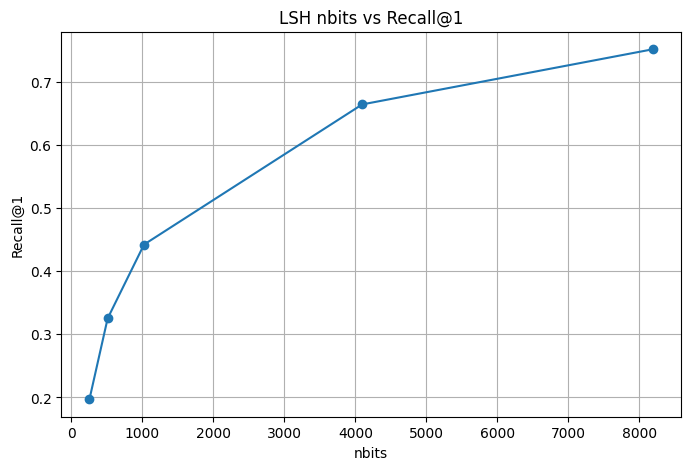

In [ ]:

nbits_list = [2*d, 4*d, 8*d, 32*d, 64*d]
recalls = []

for nbits in nbits_list:
    index_lsh = faiss.IndexLSH(d, nbits)
    index_lsh.add(xb)
    D_lsh, I_lsh = index_lsh.search(xq, k)
    recall_at_1_lsh = (I_lsh[:, 0] == I_true[:, 0]).sum() / len(xq)
    recalls.append(recall_at_1_lsh)

plt.figure(figsize=(8, 5))
plt.plot(nbits_list, recalls, marker='o')
plt.xlabel('nbits')
plt.ylabel('Recall@1')
plt.title('LSH nbits vs Recall@1')
plt.grid(True)
plt.show()

The nbits will increase the recall from 2*d to 64*d, where d is the dimension of the vectors. The storage will also increase, so we will use the nbits parameter to control the recall, memory and speed trade-off.

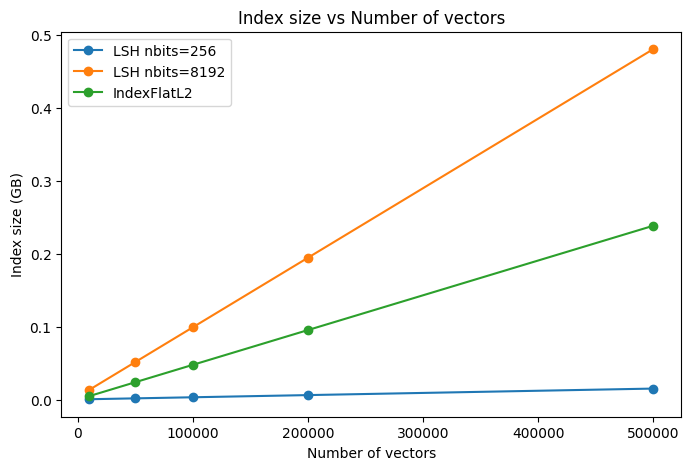

In [ ]:


# Settings
d = 128  # example dimension, set to your actual value
vector_counts = [10_000, 50_000, 100_000, 200_000, 500_000]  # example sizes

def get_index_size_bytes(index):
    import io
    buf = io.BytesIO()
    faiss.write_index(index, faiss.PyCallbackIOWriter(buf.write))
    return buf.tell()

sizes_lsh_2 = []
sizes_lsh_64 = []
sizes_flat = []

for n in vector_counts:
    xb = np.random.random((n, d)).astype('float32')
    
    # LSH nbits = d*2
    index_lsh_2 = faiss.IndexLSH(d, d*2)
    index_lsh_2.add(xb)
    size_bytes_2 = get_index_size_bytes(index_lsh_2)
    sizes_lsh_2.append(size_bytes_2 / (1024**3))
    
    # LSH nbits = d*64
    index_lsh_64 = faiss.IndexLSH(d, d*64)
    index_lsh_64.add(xb)
    size_bytes_64 = get_index_size_bytes(index_lsh_64)
    sizes_lsh_64.append(size_bytes_64 / (1024**3))
    
    # Flat index
    index_flat = faiss.IndexFlatL2(d)
    index_flat.add(xb)
    size_bytes_flat = get_index_size_bytes(index_flat)
    sizes_flat.append(size_bytes_flat / (1024**3))

plt.figure(figsize=(8, 5))
plt.plot(vector_counts, sizes_lsh_2, marker='o', label=f'LSH nbits={d*2}')
plt.plot(vector_counts, sizes_lsh_64, marker='o', label=f'LSH nbits={d*64}')
plt.plot(vector_counts, sizes_flat, marker='o', label='IndexFlatL2')
plt.xlabel('Number of vectors')
plt.ylabel('Index size (GB)')
plt.title('Index size vs Number of vectors')
plt.legend()

As expected, the memory size linearly grows with number of vectors as d is increasing

# 5. HNSW (Hierarchical Navigable Small World)

HNSW builds a graph-based structure that allows extremely fast search with high recall. It consists of multiple layers, where top layers have fewer points for coarse filtering, and bottom layers capture finer details.

In [3]:
# M is the number of connections for each node. A higher M can improve recall at the cost of memory and build time.
M = 64 # number of connections each vertex will have
index_hnsw = faiss.IndexHNSWFlat(d, M)

print("Building HNSW index...")
# efConstruction controls the quality of the graph construction(how many entry points will be explored when building the index.)
index_hnsw.hnsw.efConstruction = 128
start_time = time.time()
index_hnsw.add(xb)
end_time = time.time()
print(f"Index built in {end_time - start_time:.4f} seconds.")
print("Number of vectors in the HNSW index:", index_hnsw.ntotal)

# --- Perform a search ---
# efSearch controls the depth of search. Higher is more accurate and slower.
index_hnsw.hnsw.efSearch = 32
print(f"\nSearching all queries with HNSW (efSearch={index_hnsw.hnsw.efSearch})...")
start_time = time.time()
D_hnsw, I_hnsw = index_hnsw.search(xq, k)
end_time = time.time()
print(f"Search completed in {end_time - start_time:.4f} seconds.")


# --- Evaluate the recall ---
recall_at_1 = (I_hnsw[:, 0] == I_true[:, 0]).sum() / len(xq)
print(f"\nRecall@1 for IndexHNSWFlat: {recall_at_1:.4f}")


Building HNSW index...
Index built in 124.1984 seconds.
Number of vectors in the HNSW index: 1000000

Searching all queries with HNSW (efSearch=32)...
Search completed in 0.3879 seconds.

Recall@1 for IndexHNSWFlat: 0.9546


The recall is 0.95, which is still very good, but not as high as the brute-force search. This is expected because it only checks a subset of the data. but it is much faster than the brute-force search, making it a good choice for large datasets.The recall of 0.9546 is very impressive considering the query time is drastically reduced compared to brute-force. With appropriate tuning of parameters like M, efConstruction, and efSearch, you can get even higher recall.

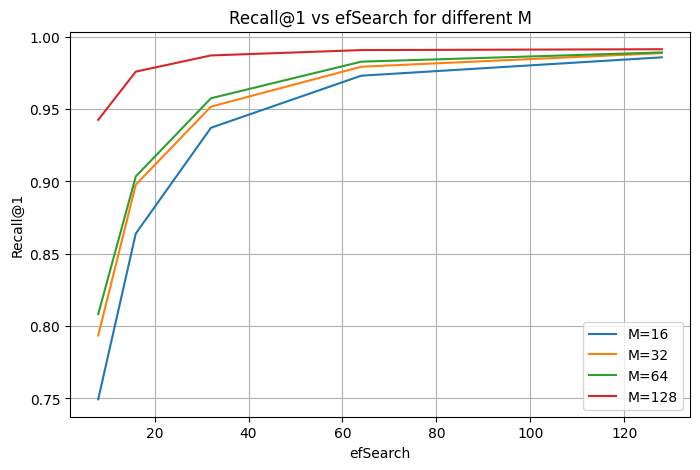

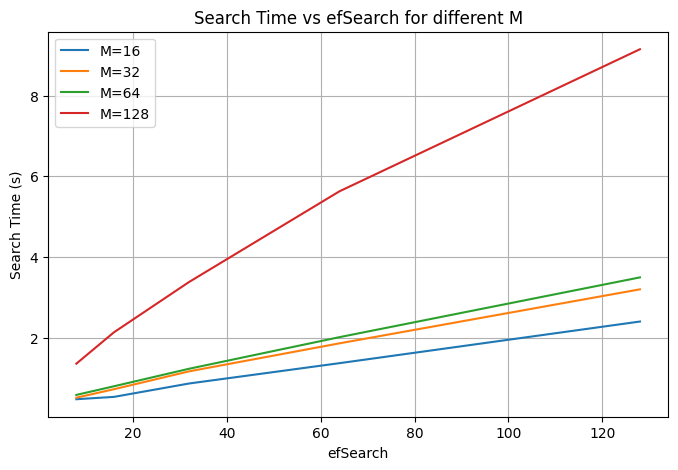

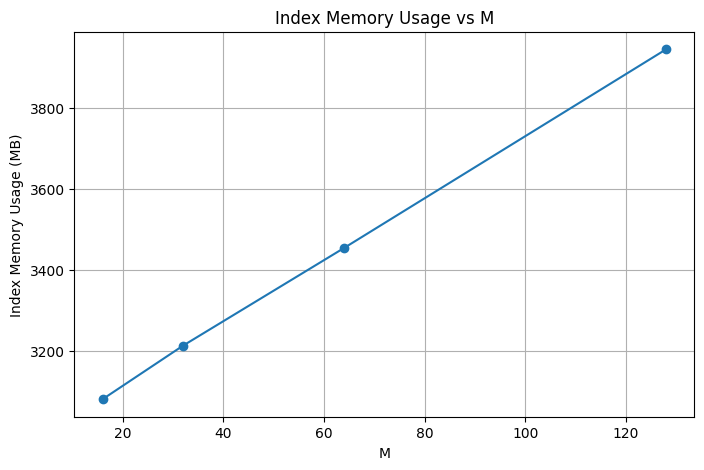

In [8]:
M_values = [16, 32, 64, 128]
efSearch_values = [8, 16, 32, 64, 128]
efConstruction_values = [32, 64, 128, 256]

recall_results = {}
search_time_results = {}
memory_usage_results = []

for M in M_values:
    recall_results[M] = []
    search_time_results[M] = []
    # Build index for each M
    index_hnsw = faiss.IndexHNSWFlat(d, M)
    index_hnsw.hnsw.efConstruction = 128  # Fixed for recall/search time plots
    index_hnsw.add(xb)
    # Measure memory usage after index is built
    process = psutil.Process()
    memory_usage_results.append(process.memory_info().rss / (1024 ** 2))  # in MB

    for efSearch in efSearch_values:
        index_hnsw.hnsw.efSearch = efSearch
        start_time = time.time()
        D_hnsw, I_hnsw = index_hnsw.search(xq, k)
        end_time = time.time()
        recall_at_1 = (I_hnsw[:, 0] == I_true[:, 0]).sum() / len(xq)
        recall_results[M].append(recall_at_1)
        search_time_results[M].append(end_time - start_time)

# Plot Recall@1 vs efSearch
plt.figure(figsize=(8, 5))
for M in M_values:
    plt.plot(efSearch_values, recall_results[M], label=f'M={M}')
plt.xlabel('efSearch')
plt.ylabel('Recall@1')
plt.title('Recall@1 vs efSearch for different M')
plt.legend()
plt.grid(True)
plt.show()

# Plot Search Time vs efSearch
plt.figure(figsize=(8, 5))
for M in M_values:
    plt.plot(efSearch_values, search_time_results[M], label=f'M={M}')
plt.xlabel('efSearch')
plt.ylabel('Search Time (s)')
plt.title('Search Time vs efSearch for different M')
plt.legend()
plt.grid(True)
plt.show()

# Plot Memory Usage vs M
plt.figure(figsize=(8, 5))
plt.plot(M_values, memory_usage_results, marker='o')
plt.xlabel('M')
plt.ylabel('Index Memory Usage (MB)')
plt.title('Index Memory Usage vs M')
plt.grid(True)
plt.show()

M and efSearch have a high impact on search-time, recall accuracy but at higher Memomry and higher query volume to search for. The recall is 0.95, which is still very good, but not as high as the brute-force search. This is expected because it only checks a subset of the data. but it is much faster than the brute-force search, making it a good choice for larger datasets when RAM is no the issue.

# 6. Inverted File Index (IndexIVFFlat)

The IndexIVFFlat significantly speeds up searches on large datasets. It partitions the 1M vectors into cells. This requires a train step on a representative sample of the data (the sift_learn.fvecs set is perfect for this). At search time, it only checks within a small number of cells (nprobe) close to the query, avoiding a full scan. This is a classic speed-vs-accuracy tradeoff. nlist is the number of cells/clusters, and nprobe is how many of those cells to search through.

In [17]:
nlist = 4096  # A common choice for 1M vectors is sqrt(N), so around 1000. 4*sqrt(N) or 4096 is also common.
quantizer = faiss.IndexFlatL2(d) # how the vectors will be compared in the coarse quantization step
index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist) 

# Train the index on the 'learn' set
print("Training IndexIVFFlat...")
start_time = time.time()
index_ivf.train(xt)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.4f} seconds.")

# Add the full base set to the index
print("Adding vectors to the index...")
index_ivf.add(xb)
print("Number of vectors in the IVF index:", index_ivf.ntotal)

# --- Perform a search ---
index_ivf.nprobe = 16 # Higher nprobe increases accuracy and search time
print(f"\nSearching all queries with IndexIVFFlat (nprobe={index_ivf.nprobe})...")
start_time = time.time()
D_ivf, I_ivf = index_ivf.search(xq, k)
end_time = time.time()
print(f"Search completed in {end_time - start_time:.4f} seconds.")

# --- Evaluate the recall ---
recall_at_1 = (I_ivf[:, 0] == I_true[:, 0]).sum() / len(xq)
print(f"\nRecall@1 for IndexIVFFlat: {recall_at_1:.4f}")


Training IndexIVFFlat...
Training completed in 5.8563 seconds.
Adding vectors to the index...
Number of vectors in the IVF index: 1000000

Searching all queries with IndexIVFFlat (nprobe=16)...
Search completed in 1.0788 seconds.

Recall@1 for IndexIVFFlat: 0.8885


While IVF doesn't match HNSW's recall, it's still respectable at 0.8885 and significantly faster than brute-force. The indexing and training steps do add some complexity, but the speed-accuracy tradeoff is very flexible through nlist and nprobe.The recall is 0.885 with time being 1.0788 seconds for 1000 queries, which is a good balance between speed and accuracy.

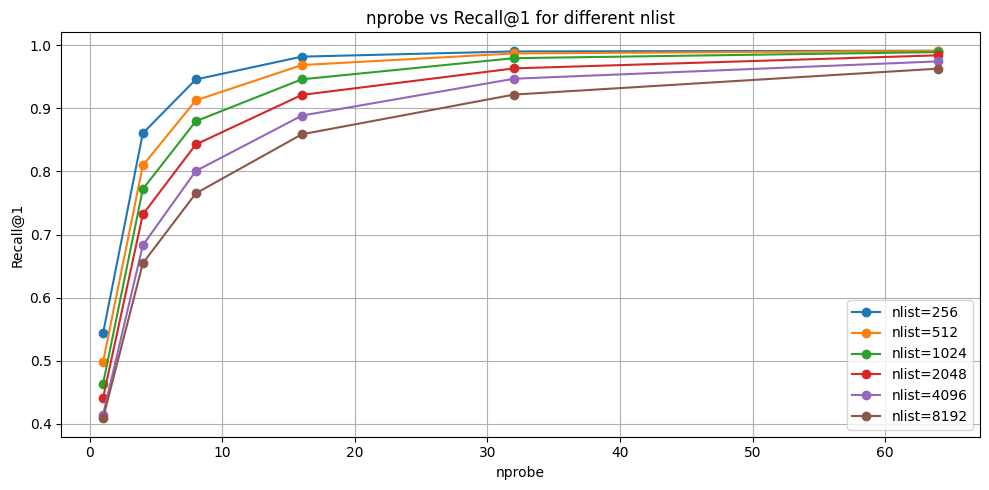

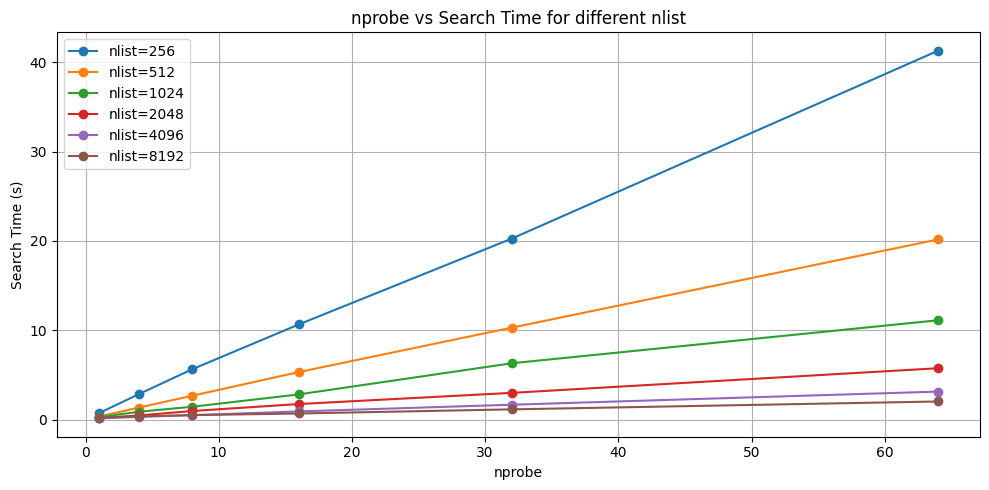

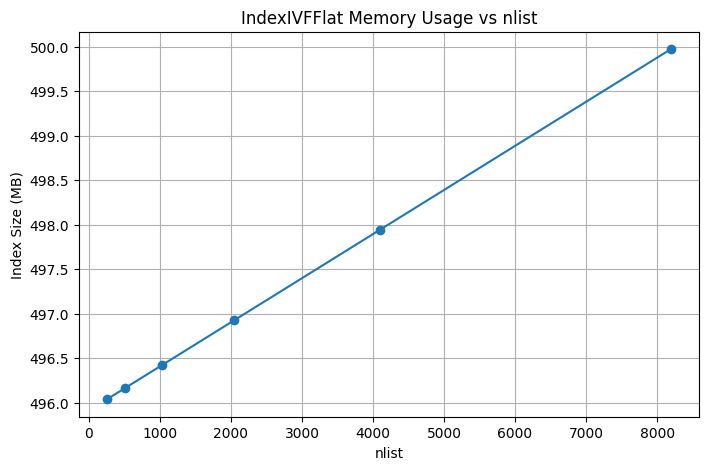

In [ ]:



nlist_values = [256, 512, 1024, 2048, 4096, 8192]
nprobe_values = [1, 4, 8, 16, 32, 64]

results = []
memory_usages = []

for nlist in nlist_values:
    quantizer = faiss.IndexFlatL2(d)
    index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist)
    index_ivf.train(xt)
    index_ivf.add(xb)
    # Measure memory usage
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        faiss.write_index(index_ivf, tmp.name)
        size_bytes = os.path.getsize(tmp.name)
    memory_usages.append(size_bytes / (1024 * 1024))  # MB
    os.remove(tmp.name)
    # Search/recall for each nprobe
    for nprobe in nprobe_values:
        index_ivf.nprobe = nprobe
        start_time = time.time()
        D_ivf, I_ivf = index_ivf.search(xq, k)
        search_time = time.time() - start_time
        recall_at_1 = (I_ivf[:, 0] == I_true[:, 0]).sum() / len(xq)
        results.append({
            'nlist': nlist,
            'nprobe': nprobe,
            'search_time': search_time,
            'recall_at_1': recall_at_1
        })

# Convert results to numpy arrays for plotting
search_times = np.array([r['search_time'] for r in results])
recalls = np.array([r['recall_at_1'] for r in results])
nlists = np.array([r['nlist'] for r in results])
nprobes = np.array([r['nprobe'] for r in results])



nlist_values_unique = sorted(set(r['nlist'] for r in results))

# Plot nprobe vs recall for each nlist
plt.figure(figsize=(10, 5))
for nlist in nlist_values_unique:
    nprobe_vals = [r['nprobe'] for r in results if r['nlist'] == nlist]
    recall_vals = [r['recall_at_1'] for r in results if r['nlist'] == nlist]
    plt.plot(nprobe_vals, recall_vals, marker='o', label=f'nlist={nlist}')
plt.xlabel('nprobe')
plt.ylabel('Recall@1')
plt.title('nprobe vs Recall@1 for different nlist')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot nprobe vs search time for each nlist
plt.figure(figsize=(10, 5))
for nlist in nlist_values_unique:
    nprobe_vals = [r['nprobe'] for r in results if r['nlist'] == nlist]
    search_time_vals = [r['search_time'] for r in results if r['nlist'] == nlist]
    plt.plot(nprobe_vals, search_time_vals, marker='o', label=f'nlist={nlist}')
plt.xlabel('nprobe')
plt.ylabel('Search Time (s)')
plt.title('nprobe vs Search Time for different nlist')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot Memory Usage vs nlist
plt.figure(figsize=(8, 5))
plt.plot(nlist_values, memory_usages, marker='o')
plt.xlabel('nlist')
plt.ylabel('Index Size (MB)')
plt.title('IndexIVFFlat Memory Usage vs nlist')
plt.grid(True)
plt.show()

The nprobe is the comparison to the number of clusters in IVF, and efConstruction is the number of edges per node in the graph. The recall hits plateau very early and is very high, but the speed is also very fast. The memory usage is also very low(<0.5Gb Compared to HNSW 3GB), making it a good choice for large datasets.

Let's Create combined plot to visualize the recall, memory and speed of each index. This will help us understand the trade-offs between different indexing strategies.

--- Loading SIFT1M Dataset ---
✅ Loaded SIFT1M Dataset
Base vectors (xb):      (1000000, 128)
Query vectors (xq):     (10000, 128)
Ground truth (I_true):  (10000, 100)
Learn vectors (xt):       (100000, 128)

--- Initializing Parameters for SIFT1M ---
Using ground truth for Recall@1 evaluation (shape: (10000, 1)).

--- Evaluating IndexFlatL2 ---
✅ Evaluation complete for IndexFlatL2 (Brute-Force)

--- Evaluating IndexLSH ---
✅ Evaluation complete for IndexLSH

--- Evaluating IndexHNSWFlat ---
  ✅ HNSW with efSearch = 8 evaluated.
  ✅ HNSW with efSearch = 16 evaluated.
  ✅ HNSW with efSearch = 32 evaluated.
  ✅ HNSW with efSearch = 64 evaluated.
  ✅ HNSW with efSearch = 128 evaluated.
  ✅ HNSW with efSearch = 256 evaluated.

--- Evaluating IndexIVFFlat ---
  ✅ IVFFlat with nprobe = 1 evaluated.
  ✅ IVFFlat with nprobe = 4 evaluated.
  ✅ IVFFlat with nprobe = 8 evaluated.
  ✅ IVFFlat with nprobe = 16 evaluated.
  ✅ IVFFlat with nprobe = 32 evaluated.
  ✅ IVFFlat with nprobe = 64 evaluate

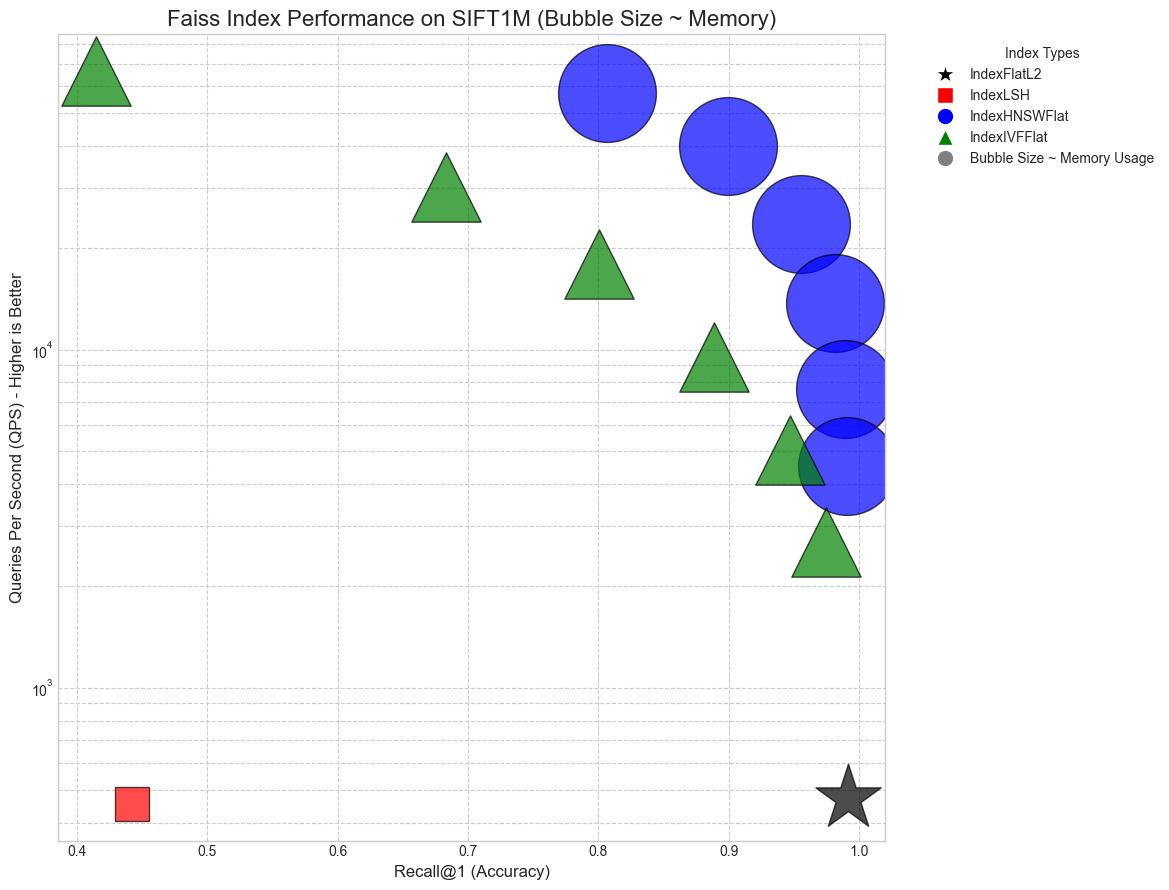

In [ ]:
# Keep the imports in this cell for compiling this with out running the entire notebook

import os
import faiss
import matplotlib.pyplot as plt
import time
import pandas as pd
import tempfile
import gc


# Constants

sift_dir = "sift"
base_file = f"{sift_dir}/sift_base.fvecs"
query_file = f"{sift_dir}/sift_query.fvecs"
gt_file = f"{sift_dir}/sift_groundtruth.ivecs"
learn_file = f"{sift_dir}/sift_learn.fvecs"




# Loaders
def read_fvecs(filename):
    """Reads fvecs file format."""
    with open(filename, "rb") as f:
        # First 4 bytes are the vector dimension
        d = np.fromfile(f, dtype=np.int32, count=1)[0]
        f.seek(0)
        # Read the whole file as float32
        data = np.fromfile(f, dtype=np.float32)
        # Reshape into (N, d+1) and slice off the first column (dimension)
        return data.reshape(-1, d + 1)[:, 1:].copy()

def read_ivecs(filename):
    """Reads ivecs file format."""
    with open(filename, "rb") as f:
        # First 4 bytes are the vector dimension
        d = np.fromfile(f, dtype=np.int32, count=1)[0]
        f.seek(0)
        # Read the whole file as int32
        data = np.fromfile(f, dtype=np.int32)
        # Reshape into (N, d+1) and slice off the first column (dimension)
        return data.reshape(-1, d + 1)[:, 1:].copy()

# Load data
print("--- Loading SIFT1M Dataset ---")
xb = read_fvecs(base_file)
xq = read_fvecs(query_file)
I_true = read_ivecs(gt_file)
xt = read_fvecs(learn_file)
print("✅ Loaded SIFT1M Dataset")
print(f"Base vectors (xb):      {xb.shape}")
print(f"Query vectors (xq):     {xq.shape}")
print(f"Ground truth (I_true):  {I_true.shape}")
print(f"Learn vectors (xt):       {xt.shape}")


# --- Part 2: Index Comparison Framework ---

# --- 1. Data and Ground Truth Setup ---
print("\n--- Initializing Parameters for SIFT1M ---")
d = xb.shape[1]      # Dimension of vectors
nq = xq.shape[0]     # Number of query vectors

# The loaded ground truth contains the top 100 nearest neighbors.
# For Recall@1, we only need the single closest neighbor (the first column).
I_true_1 = I_true[:, :1]
print(f"Using ground truth for Recall@1 evaluation (shape: {I_true_1.shape}).")


# --- 2. Evaluation Framework ---
results = []
k_search = 100  # Number of nearest neighbors to retrieve during tests

def get_memory_usage(index):
    """Measures the memory usage of a Faiss index in MB."""
    # Faiss provides a utility to get the index size directly for some indexes,
    # but writing to a temporary file is a universal method.
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        faiss.write_index(index, tmp.name)
        size_mb = os.path.getsize(tmp.name) / (1024 * 1024)
    os.remove(tmp.name)
    return size_mb

def evaluate(index, index_name, is_trained=False):
    """Helper function to evaluate build, memory, search, and recall."""
    gc.collect() # Clean up memory before measurements

    # --- Build Time ---
    t0 = time.time()
    if not is_trained: # For indexes like HNSW that don't need separate training
        index.train(xt)
    index.add(xb)
    build_time = time.time() - t0

    # --- Memory Usage ---
    memory_usage = get_memory_usage(index)

    # --- Search Time & Recall ---
    t0 = time.time()
    D, I = index.search(xq, k_search)
    search_time = time.time() - t0

    recall_at_1 = (I[:, 0] == I_true_1[:, 0]).sum() / nq

    # --- Store results ---
    results.append({
        "Index": index_name,
        "Build Time (s)": build_time,
        "Search Time (s)": search_time,
        "QPS": nq / search_time,
        "Recall@1": recall_at_1,
        "Memory (MB)": memory_usage
    })
    print(f"✅ Evaluation complete for {index_name}")


# --- 3. Evaluate Each Index Configuration ---

# ====== Index 1: IndexFlatL2 (The Reference) ======
print("\n--- Evaluating IndexFlatL2 ---")
index_flat = faiss.IndexFlatL2(d)
evaluate(index_flat, "IndexFlatL2 (Brute-Force)", is_trained=True) # is_trained=True skips the .train() step

# ====== Index 2: IndexLSH (Locality-Sensitive Hashing) ======
print("\n--- Evaluating IndexLSH ---")
nbits = d * 8  # A common choice for nbits
index_lsh = faiss.IndexLSH(d, nbits)
evaluate(index_lsh, "IndexLSH", is_trained=True)

# ====== Index 3: IndexHNSWFlat (Hierarchical Navigable Small World) ======
print("\n--- Evaluating IndexHNSWFlat ---")
M = 64
index_hnsw = faiss.IndexHNSWFlat(d, M)
index_hnsw.hnsw.efConstruction = 128

# Build (once)
t0 = time.time()
index_hnsw.add(xb)
hnsw_build_time = time.time() - t0
hnsw_memory = get_memory_usage(index_hnsw)

efSearch_values = [8, 16, 32, 64, 128, 256]
for ef in efSearch_values:
    index_hnsw.hnsw.efSearch = ef
    t0 = time.time()
    D_hnsw, I_hnsw = index_hnsw.search(xq, k_search)
    search_time = time.time() - t0
    recall = (I_hnsw[:, 0] == I_true_1[:, 0]).sum() / nq
    results.append({
        "Index": f"HNSW (efSearch={ef})", "Build Time (s)": hnsw_build_time,
        "Search Time (s)": search_time, "QPS": nq / search_time,
        "Recall@1": recall, "Memory (MB)": hnsw_memory
    })
    print(f"  ✅ HNSW with efSearch = {ef} evaluated.")

# ====== Index 4: IndexIVFFlat (Inverted File) ======
print("\n--- Evaluating IndexIVFFlat ---")
nlist = 4096  # A common choice for SIFT1M (around 4*sqrt(N))
quantizer = faiss.IndexFlatL2(d)
index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist)

# Train and Build (once)
t0 = time.time()
index_ivf.train(xt)
index_ivf.add(xb)
ivf_build_time = time.time() - t0
ivf_memory = get_memory_usage(index_ivf)

nprobe_values = [1, 4, 8, 16, 32, 64]
for nprobe in nprobe_values:
    index_ivf.nprobe = nprobe
    t0 = time.time()
    D_ivf, I_ivf = index_ivf.search(xq, k_search)
    search_time = time.time() - t0
    recall = (I_ivf[:, 0] == I_true_1[:, 0]).sum() / nq
    results.append({
        "Index": f"IVFFlat (nprobe={nprobe})", "Build Time (s)": ivf_build_time,
        "Search Time (s)": search_time, "QPS": nq / search_time,
        "Recall@1": recall, "Memory (MB)": ivf_memory
    })
    print(f"  ✅ IVFFlat with nprobe = {nprobe} evaluated.")

# --- 4. Display Results in a Table ---
df = pd.DataFrame(results).set_index('Index')
print("\n\n--- Comparison Summary on SIFT1M ---")
print(df.to_string(formatters={
    "Build Time (s)": "{:.3f}".format,
    "Search Time (s)": "{:.3f}".format,
    "QPS": "{:,.0f}".format,
    "Recall@1": "{:.4f}".format,
    "Memory (MB)": "{:.2f}".format
}))

# --- 5. Visualization ---
print("\n--- Generating Performance Plot ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 9))

colors = {'Brute-Force': 'black', 'LSH': 'red', 'HNSW': 'blue', 'IVF': 'green'}
markers = {'Brute-Force': '*', 'LSH': 's', 'HNSW': 'o', 'IVF': '^'}

for index_name, row in df.iterrows():
    base_type = 'HNSW' if 'HNSW' in index_name else \
                'IVF' if 'IVF' in index_name else \
                'LSH' if 'LSH' in index_name else 'Brute-Force'

    ax.scatter(row['Recall@1'], row['QPS'], s=row['Memory (MB)'] * 5,
               c=colors[base_type], marker=markers[base_type],
               alpha=0.7, edgecolors='black')

ax.set_xlabel('Recall@1 (Accuracy)', fontsize=12)
ax.set_ylabel('Queries Per Second (QPS) - Higher is Better', fontsize=12)
ax.set_title('Faiss Index Performance on SIFT1M (Bubble Size ~ Memory)', fontsize=16)
ax.set_yscale('log')
ax.set_xscale('linear')
ax.grid(True, which="both", ls="--")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='*', color='w', label='IndexFlatL2', markerfacecolor=colors['Brute-Force'], markersize=15),
    Line2D([0], [0], marker='s', color='w', label='IndexLSH', markerfacecolor=colors['LSH'], markersize=12),
    Line2D([0], [0], marker='o', color='w', label='IndexHNSWFlat', markerfacecolor=colors['HNSW'], markersize=12),
    Line2D([0], [0], marker='^', color='w', label='IndexIVFFlat', markerfacecolor=colors['IVF'], markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Bubble Size ~ Memory Usage', markerfacecolor='gray', markersize=12)
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.04, 1), loc='upper left', title="Index Types")
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

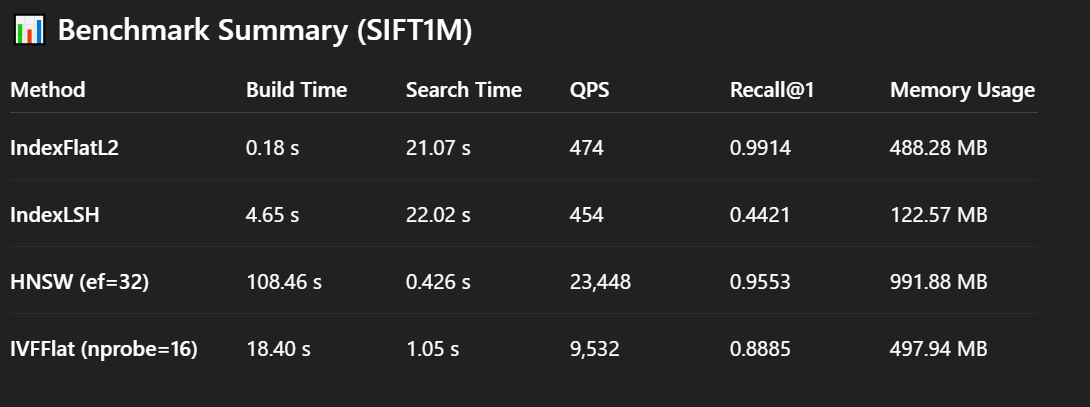

# Conclusion & Comparison
This guide has demonstrated four fundamental Faiss indexes on the SIFT1M dataset:

HNSW is the Winner for High Performance: If your application requires both high speed and high accuracy (e.g., >90% recall), IndexHNSWFlat is the clear choice. You can tune efSearch to get the exact balance you need.

IVF is a Flexible but Less Efficient Alternative: IndexIVFFlat can also be tuned for performance, but in this test, it's outperformed by HNSW in both speed. Its main advantage in other scenarios  is when combined with Product Quantization (IndexIVFPQ) to achieve massive memory reduction So If the memory is a concern, consider using IndexIVFPQ.

Avoid LSH for this Dataset: The performance of IndexLSH is too poor to be considered.

The Price of Perfection is Too High: IndexFlatL2 shows that achieving 100% accuracy is computationally very expensive and not feasible for real-time services. ANN indexes like HNSW demonstrate that you can get very close to perfect recall (98-99%) at a tiny fraction of the computational cost and time.



# References
- [Pinecone Blog Series on Vector Indexes](https://www.pinecone.io/learn/vector-indexes/)
- [Faiss Documentation](https://faiss.ai/)
- [SIFT1M Dataset](http://corpus-texmex.irisa.fr/sift1M.tar.gz)

